# Classification 1 – distance measures and Nearest Neighbour classification

## Introduction

In this notebook we will expand on some of the concepts of 
classification, starting with an experiment with distance measures on data, then looking into the $k$-Nearest Neighbour algorithm. Please try to understand the code and follow instructions marked in <font color='purple'>purple</font> color.

1) Distance measures for high-dimensionality data

Algorithms such as $k$-Nearest Neighbour are conceptually very simple -- we predict the class value of an unlabelled *query* data point we are given by looking at all the labelled data point(s) in our data set, and predicting that our query will have the same class as the most similar data point(s) in the training set. So, all we need is a way of measuring similarity. The well-known *Euclidean distance measure* would seem to be a good choice. However, while we are very familiar with Euclidean distance in 2 and 3-dimensions, there is a problem with high-dimensions –  <font color='purple'>what is this problem</font> ? 

### Pairwise distances in high-dimensional spaces 

 <font color='green'>**Answer**: in high-dimensional spaces everything is far away from everything else, and so pairwise distances become uninformative</font>.

But what does this actually mean ? There is a mathematical argument to show that this is a true statement, but an alternative approach is simply to simulate what happens. One approach is to randomly generate $N$ points inside a $d$-dimensional cube centred around zero, such as $[-0.5, 0.5]^{d}$. Now we calculate the pairwise distances among the $N$ points.  After that for every data point we calculate the ratio of the minimum distance to the maximum distance  to all of the other data points. The mean ratio represents the average range of pairwise distances there are in that dimensionality. We run the simulation from 1 dimension to 1000 dimensions and the ratios will be plotted on a line chart using the ``` matplotlib ``` library. 

You should use the ```numpy``` library for this, and in particular the linear algebra methods to calculate distances such as the [L2 norm](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.norm.html#numpy.linalg.norm). 

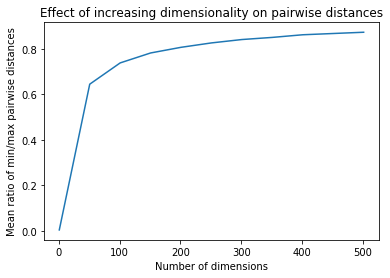

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def run_d_n(dim,N_pts,L):
    pts=np.random.rand(N_pts,dim)-0.5 # simulate N_pts points on dim dimensions space
    ratio_list=[]
    for i in range(N_pts):
        # ignore the data point itself
        selected_pts=np.array([j for j in range(N_pts) if j!=i])
        # calculate the L2 or L1 distance with other points
        dist=np.linalg.norm(pts[selected_pts]-pts[i],L,axis=1)
        # calculate the ratio of the min. distance to the max. distance
        ratio=np.min(dist)/np.max(dist)
        ratio_list.append(ratio)
    # output the mean ratio
    return np.mean(ratio_list)

# Initialise the N_pts, the number of points we simulate
N_pts=200
# Setting l=2 to calculate the L2 distance
l=2
# Setting the number of dimensions we simulate
check_dim=range(1,550,50)
# Calculate the mean ratio on that dimension
ratio_list=[ run_d_n(dim,N_pts,l) for dim in check_dim]
# Plot the ratio with its corresponding dimension
plt.plot(check_dim,ratio_list)
plt.ylabel("Mean ratio of min/max pairwise distances")
plt.xlabel("Number of dimensions")
plt.title("Effect of increasing dimensionality on pairwise distances")
plt.xticks(np.arange(0, 600, step=100))
plt.show()

 <font color='purple'>**Question:** how can this plot be interpreted ? How else could you visualize this effect</font> ?

In [ ]:
As the number of dimensons increases, the average ratio of min/max pairwise distances between points in the space 
approaches 1 i.e. min dist = max distance
which means all points become almost equidistant i.e. "in high-dimensional spaces everything is far away
from everything else, and so pairwise distances become uninformative."

Another way to visualise this effect would be to plot the distances between two points we know to be very similar.. and two points 
known to be very different and see how close they are... or just plot every distance btween points and see that the distance is the same?

## 2) Implement Nearest Neighbour from scratch

The following will give some practise in implementing a simple classifier, the $k$-Nearest Neighbour ($k$NN) algorithm. It should help us to write a $k$NN package from scratch. Most machine learning methods include two main steps, namely training (fitting to a model to the training data) and prediction (running the model on input data  to generate output). However, in the $k$NN algorithm, since there is no explicit model-building step, we only require implementation of the prediction step without a training step.

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Data Creation

In [4]:
mean_01 = np.array([1, 0.5]) # corrdinate of the mean
cov_01 = np.array([[1, 0.1], [0.1, 1.2]])

mean_02 = np.array([4, 5])
cov_02 = np.array([[1, 0.1], [0.1, 1.2]]) # the covariance matrix element ij is the covariance ofxi  and xj 
#Draw random samples from a multivariate normal distribution.
#The multivariate normal, multinormal or Gaussian distribution is a generalization of the one-dimensional normal 
#distribution to higher dimensions. Such a distribution is specified by its mean and covariance matrix. 
#These parameters are analogous to the mean (average or “center”) 
#and variance (standard deviation, or “width,” squared) of the one-dimensional normal distribution.
dist_01 = np.random.multivariate_normal(mean_01, cov_01, 500)
dist_02 = np.random.multivariate_normal(mean_02, cov_02, 500)
print(dist_01.shape, dist_02.shape)

(500, 2) (500, 2)


We have created two 2-dimensional normal distributions of data points with the same covariance but different means.

## Plotting the created Data 

<font color='purple'>What does the data look like ? Notice the 2 unique clusters being formed.</font>

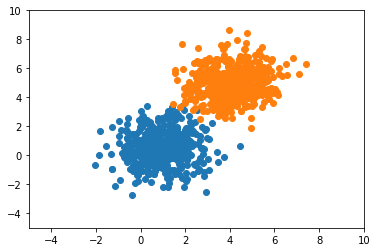

In [5]:
plt.figure(0)
plt.xlim(-5, 10)
plt.ylim(-5, 10)

plt.scatter(dist_01[:, 0], dist_01[:, 1])
plt.scatter(dist_02[:, 0], dist_02[:, 1])#, color='red')
plt.show()

Let us now represent it in a tabular way. We will have dist_01 getting label 1.

In [18]:
r = dist_01.shape[0] + dist_02.shape[0]
c = dist_01.shape[1] + 1
data = np.zeros((r, c))
print(data.shape)
#advanced indexing:
#x = np.array([[1, 2], [3, 4], [5, 6]]) 
#y = x[[0,1,2], [0,1,0]]  means x[cols,rows] means output is from rows 0,1,2 cols 0,1,0 i.e (0,0) (1,1)(2,0) =[1,4,5]
data[:dist_01.shape[0], :2] = dist_01 #  all rows of dis01 from first row, all columns up to 2 have dist01 data...
data[dist_01.shape[0]:, :2] = dist_02 # all rows after the above, all columns up to 2 have dist02 data ...
data[dist_01.shape[0]:, -1] = 1.0 # all rows , last column (2rd col) is 1
print(data)

print(data.mean(axis=0))

(1000, 3)
[[-0.47684927 -0.92265375  0.        ]
 [ 0.03177491  1.96825434  0.        ]
 [ 1.34951765  1.77459421  0.        ]
 ...
 [ 3.76551825  4.95656495  1.        ]
 [ 6.8476356   6.7432001   1.        ]
 [ 5.47683307  6.08170847  1.        ]]
[2.48042793 2.77183805 0.5       ]


Now shuffle the data and check by printing the first 10 rows.

In [17]:
np.random.shuffle(data)
print(data[:10])

[[ 4.73338485  5.94308369  1.        ]
 [ 2.18735043 -0.02612474  0.        ]
 [ 0.50378992  1.1513019   0.        ]
 [ 2.59448937  6.35287751  1.        ]
 [ 0.44237253 -0.33054287  0.        ]
 [ 5.21395998  4.93747631  1.        ]
 [ 0.51104315 -0.3472499   0.        ]
 [ 1.5387969   5.65171218  1.        ]
 [ 1.29065693  0.06369912  0.        ]
 [-0.75303647  0.14314048  0.        ]]


**Implementation.** Next, we implement our KNN algorithm. There are many ways to do this, but a basic approach will require a pairwise distance measure for instances, and a way to take a "training" dataset of classified instances and make a prediction for a "test" data instance. Here is a top-level outline.

<font color='purple'>Please add an impelemtation code. Use Manhattan (L2) distance</font>.

In [37]:
def distance(x1, x2):
    return sum(abs(x1-x2)) #vectors x1,x2
    
def knn(X_train, y_train, xt, k=7):
    #find k nearest neighbours 
    distances = [] # stores row in X_train/sample # and distance from xt
    neighbors = [] #list of row/sample #s
    votes = {}
    for i in range(0, X_train.shape[0]):
        dist = distance(X_train[i], xt)
        distances.append((i, dist))
    distances.sort(key=lambda item: item[1]) # sort by distance
    for x in range(k): #0...k, first k sorted by increasing distance
        #print distances[x]
        #neighbors.append(distances[x][0])
        y_val=y_train[distances[x][0]]
        if y_val not in votes:
            votes[y_val]=1
        else:
            votes[y_val]+=1
   #now we get the y values/votes for th ek nearest neighbours and return the most popular!
    sorted_votes=[(k,v) for k, v in sorted(votes.items(), key=lambda item: item[1])]
    #get the top key
    return sorted_votes[0][0]
 
        
    
    

<font color='purple'>Now check to see if we can make a prediction</font>.

In [38]:
test_point = np.array([8, -4])

# Un-comment the line below and check if it comes out as 0.0  
print(knn(data[:, :2], data[:, -1], test_point))

0.0


## Create a train and test split of the data

In [48]:
np.random.shuffle(data)
split = int(0.75 * data.shape[0])
# print split
train_data_X = data[:split, :2]
train_data_y = data[:split, -1]
test_data_X = data[split:, :2]
test_data_y = data[split:, -1]

print(train_data_X.shape, train_data_y.shape)
print(test_data_X.shape, test_data_y.shape)

(750, 2) (750,)
(250, 2) (250,)


<font color='purple'>**Implementation.** Next, please add an implementation to run our KNN classifier on all the test data and get the results</font>. 

In [49]:



# kx is the number of neighbours
def get_acc(train_data_X,train_data_y,test_data_X, test_data_y,kx):

    # for all test data samples, 
    #compare predicted y, from trianing samples, to actual test data y
    correct_predictions=0
    for i in range(0, test_data_X.shape[0]):
        predicted_y=knn(train_data_X, train_data_y, test_data_X[i], kx)
        if(predicted_y==test_data_y[i]):
            correct_predictions+=1
    
    return float( (1/test_data_X.shape[0]) * correct_predictions )
   

print(get_acc(train_data_X,train_data_y,test_data_X, test_data_y,7))

0.984


<font color='purple'>What accuracy did you get ? You should get around 99 percent on this dataset</font>. 

## Now let's try real data : MNIST

In [50]:
import pandas as pd
import datetime

Of course, MNIST is image data, but here we are using a CSV version where we can view the pixels as numbers (each row has the pixel data for an image of a digit, and the first column is the class of the digit, i.e., 0-9).

In [52]:
df = pd.read_csv('train(1).csv')
df.head()

,5,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.608,0.609,0.610,0.611,0.612,0.613,0.614,0.615,0.616,0.617
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Since the dataset is quite big, we will just use a subset.

In [53]:
data = df.values[:2000]
print (data.shape)

(2000, 785)


Make a train/test split of the data.

In [59]:
split = int(0.8 * data.shape[0])

X_train = data[:split, 1:] #first column is the class of the digit,
                            #i.e., 0-9 so we exlude it from train set

X_test = data[split:, 1:]

y_train = data[:split, 0] #Image classes
y_test = data[split:, 0]

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(1600, 784) (1600,)
(400, 784) (400,)


Let us just check that our data really does represent images.

4


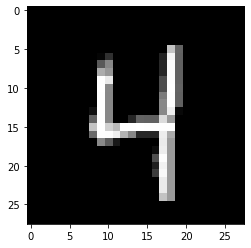

In [60]:
plt.figure(0)
plt.imshow(X_train[91].reshape((28, 28)), cmap='gray', interpolation='none')
print (y_train[91])
plt.show()

<font color='purple'>**Implementation.** Now code another ```get_acc()``` and try different values of K on our dataset</font>.

In [66]:
print(get_acc(X_train,y_train,X_test, y_test,10))
print(30)
#print (get_acc(kx=))

0.4975
30


<font color='purple'>Try different values of k and observe how the results changes. Which k gives the best result and why?</font>.

<font color='purple'>Now explore different metrics: precision, recall, F1 and confusion matrix. Use ```sklearn.neighbors KNeighborsClassifier``` to obtain predictions and ```sklearn.metrics``` to do the calculations</font>.